# Regression for supervised learning

_UNDER CONSTRUCTION_

- subset selection, partial least squares, ridge, gradient boost, random forest
- sklearn, statsmodels



In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from pandas.api.types import is_list_like, is_numeric_dtype
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error    
import time
from finds.readers.alfred import Alfred, fred_qd, fred_md
from finds.plots import plot_date
from finds.misc.show import Show
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0
show = Show(ndigits=4, latex=None)

imgdir = paths['images'] / 'regression'
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=-1)

### Get FRED-MD INDPRO data
df, t = fred_md(202205)
transforms = t['transform']

### Splice in common updates: source of PE ratio, Commercial Paper
for col in ['S&P PE ratio', 'CP3M']:
    df[col] = alf.splice(col)
df['COMPAPFF'] = df['COMPAPFF'].fillna(method='ffill')  # forward fill 20200430

### Apply transformations
transformed = []
freq = 'M' 
beg = 19640701  # 19620701
end = 20220331  # ignore 2020?
for col in df.columns:
    transformed.append(alf.transform(df[col], tcode=transforms[col], freq=freq))
data = pd.concat(transformed, axis=1).iloc[2:]
c = list(data.columns)
data = data.loc[(data.index >= beg) & (data.index <= end)]

### Drop columns with missing data
missing = []
for series_id in df.columns:
    g = data[series_id].notna()
    missing.extend([(date, series_id) for date in data.index[~g]])
missing_per_row = data.isna().sum(axis=1)
missing = DataFrame.from_records(missing, columns=['date', 'series_id'])
print('original:', data.shape, 'dropna:', data.dropna(axis=1).shape)
data = data.dropna(axis=1)   # drop columns where missing values
print(missing['series_id'].value_counts())
data

### Split time series train (througn 2017) and test set (17+ quarters)
target_id = 'INDPRO'
def ts_split(X, Y, end=20171231):
    """helper to split train/test time series"""
    return X[Y.index<=end], X[Y.index>end], Y[Y.index<=end], Y[Y.index>end]
def columns_map(columns, lag):
    return {col: col + '_' + str(lag) for col in columns}
def columns_unmap(columns):
    cols = [col.split('_') for col in columns]
    return [col[0] for col in cols], [int(col[1]) for col in cols]

lags = 3   # Include up to 3 lags of exogs
Y = data[target_id].iloc[lags:]
X = pd.concat([data.shift(lag).iloc[lags:]\
               .rename(columns=columns_map(data.columns, lag))
               for lag in range(1, lags+1)],
              axis=1)
test = Series(name='test', dtype=float)    # collect test and train errors
test_robust = Series(name='test_no_extremes', dtype=float)
train = Series(name='train', dtype=float)
final_models = {}                          # collect final fitted models

monthly/2022-05.csv
original: (693, 127) dropna: (693, 122)
series_id
CP3M            393
ACOGNO          332
UMCSENT         163
TWEXAFEGSMTH    103
ANDENO           44
Name: count, dtype: int64


## Forward Selection


,name,train,test_robust,test
RMSE,Forward Subset Regression (k=22),0.005459,0.015444,0.020698


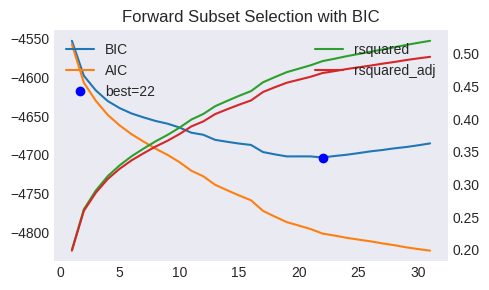

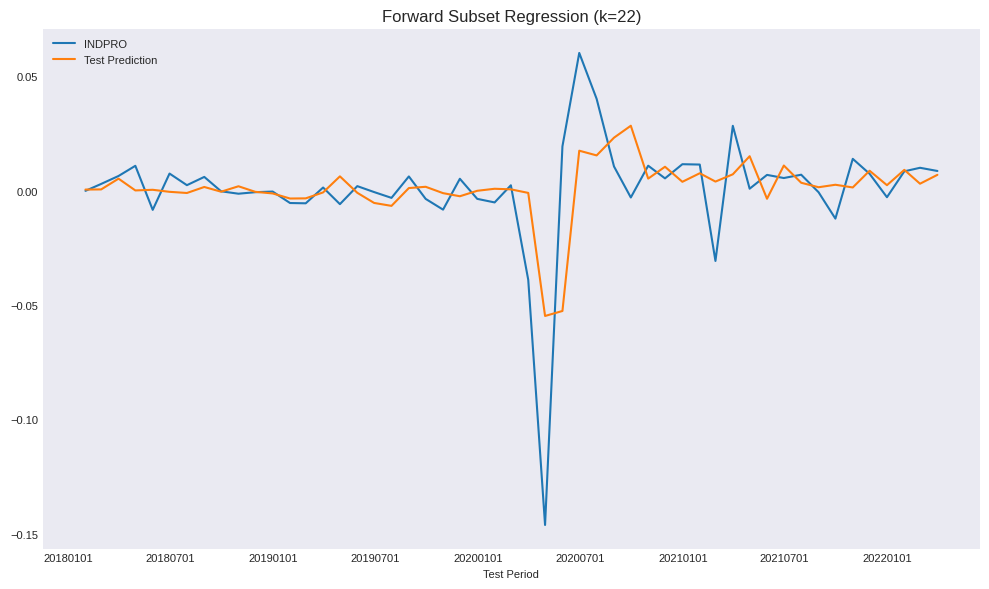

In [2]:
def forward_select(Y, X, selected, ic='aic'):
    """helper to forward select next regressor, using sm.OLS"""
    remaining = [x for x in X.columns if x not in selected]
    results = []
    for x in remaining:
        r = sm.OLS(Y, X[selected + [x]]).fit()
        results.append({'select': x,
                        'aic': r.aic,
                        'bic': r.bic,
                        'rsquared': r.rsquared,
                        'rsquared_adj': r.rsquared_adj})
    return DataFrame(results).sort_values(by=ic).iloc[0].to_dict()

### split train/test and forward select
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
tic = time.time()
selected = []
models = {}

### find best bic, and show selection criteria scores
ic = 'bic'   # select by information criterion
for i in range(1, 32):
    select = forward_select(Y_train,
                            X_train,
                            selected,
                            ic=ic)
    models.update({i: select})
    selected.append(select['select'])
selected = DataFrame.from_dict(models, orient='index')
best = selected[[ic]].iloc[selected[ic].argmin()]
subset = selected.loc[:best.name].round(3)
subset.index = [alf.header(s.split('_')[0]) for s in subset['select']]
show(subset, caption='Forward Selection Subset', max_colwidth=60)


DataFrame.from_dict({n: {'series_id': s.split('_')[0],
                         'lag' : s.split('_')[1],
                         'description': alf.header(s.split('_')[0])}
                     for n, s in selected.loc[:best.name, 'select'].items()},
                    orient='index').set_index('series_id')

### Plot BIC vs number selected
fig, ax = plt.subplots(num=1, clear=True, figsize=(5, 3))
selected['bic'].plot(ax=ax, c='C0')
selected['aic'].plot(ax=ax, c='C1')
ax.plot(best.name, float(best.iloc[0]), "ob")
ax.legend(['BIC', 'AIC', f"best={best.name}"], loc='upper left')
ax.set_title(f"Forward Subset Selection with {ic.upper()}")
bx = ax.twinx()
selected['rsquared'].plot(ax=bx, c='C2')
selected['rsquared_adj'].plot(ax=bx, c='C3')
bx.legend(['rsquared', 'rsquared_adj'], loc='upper right')
bx.set_xlabel('# Predictors')
plt.tight_layout()
plt.savefig(imgdir / 'forward.jpg')

### evaluate train and test mse
X_subset = X_train[subset['select']]
model = sm.OLS(Y_train, X_subset).fit()
name = f"Forward Subset Regression (k={len(subset)})"
Y_pred = model.predict(X_test[subset['select']])
test[name] = mean_squared_error(Y_test, Y_pred)                               
robust = Y_test.abs() < 2.33 * np.std(Y_test)
test_robust[name] = mean_squared_error(Y_test[robust], Y_pred[robust])
train[name] = mean_squared_error(Y_train, model.predict(X_subset))
final_models[name] = model
fig, ax = plt.subplots(figsize=(10,6))
plot_date(pd.concat([Y_test, Y_pred], axis=1),
          legend1=[target_id, 'Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()
plt.savefig(imgdir / 'forward_test.jpg')

DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test_robust': np.sqrt(test_robust[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

## Partial Least Squares Regression


,name,train,test_robust,test
RMSE,PLS Regression,0.00597,0.018655,0.028461


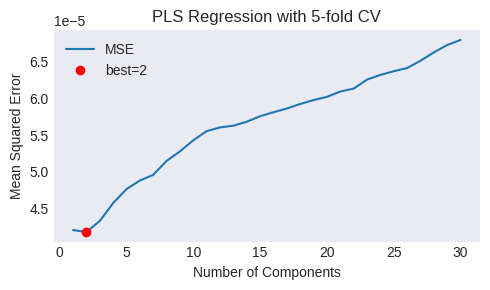

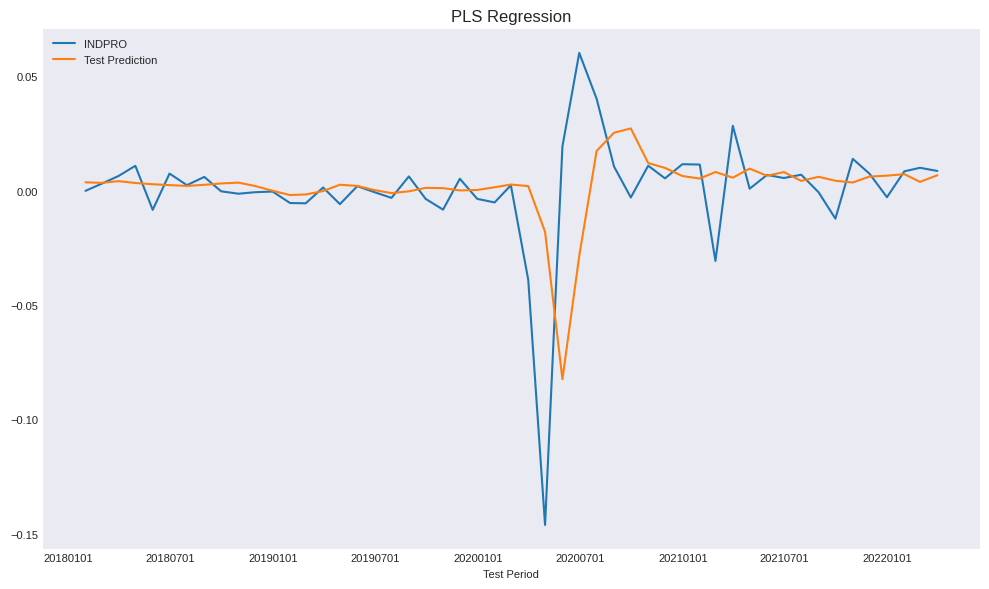

In [10]:
### - split train and test, fit standard scaling using train set
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, KFold
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

### fit with 5-fold CV to choose n_components
n_splits=5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
mse = Series(dtype=float)
for i in np.arange(1, 31):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(estimator=pls,
                            X=X_train,
                            y=Y_train,
                            n_jobs=-1,
                            verbose=VERBOSE,
                            cv=kf,
                            scoring='neg_mean_squared_error').mean()
    mse.loc[i] = -score

### show CV results and best model
fig, ax = plt.subplots(clear=True, num=1, figsize=(5, 3))
mse.plot(ylabel='Mean Squared Error',
         xlabel='Number of Components',
         title=f"PLS Regression with {n_splits}-fold CV",
         ax=ax)
best = mse.index[mse.argmin()]
ax.plot(best, mse.loc[best], "or")
ax.legend(['MSE', f"best={best}"])
plt.tight_layout()
plt.savefig(imgdir / 'pls.jpg')

### evaluate train and test mse
model = PLSRegression(n_components=best).fit(X_train, Y_train)
name = f"PLS Regression"
Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))

test[name] = mean_squared_error(Y_test, Y_pred)
robust = Y_test.abs() < 2.33 * np.std(Y_test)
test_robust[name] = mean_squared_error(Y_test[robust], Y_pred[robust])
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

fig, ax = plt.subplots(figsize=(10,6))
plot_date(pd.concat([Y_test, Y_pred], axis=1),
          legend1=[target_id, 'Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()
plt.savefig(imgdir / 'pls_test.jpg')


DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test_robust': np.sqrt(test_robust[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

#

## Ridge Regression


,name,train,test_robust,test
RMSE,Ridge (alpha=1238.5),0.005482,0.020216,0.027426


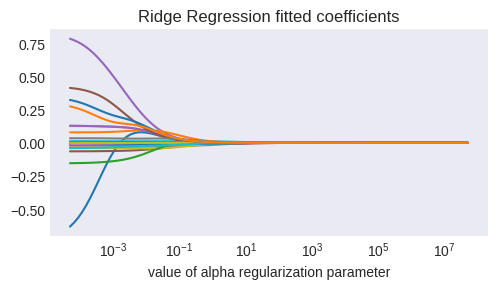

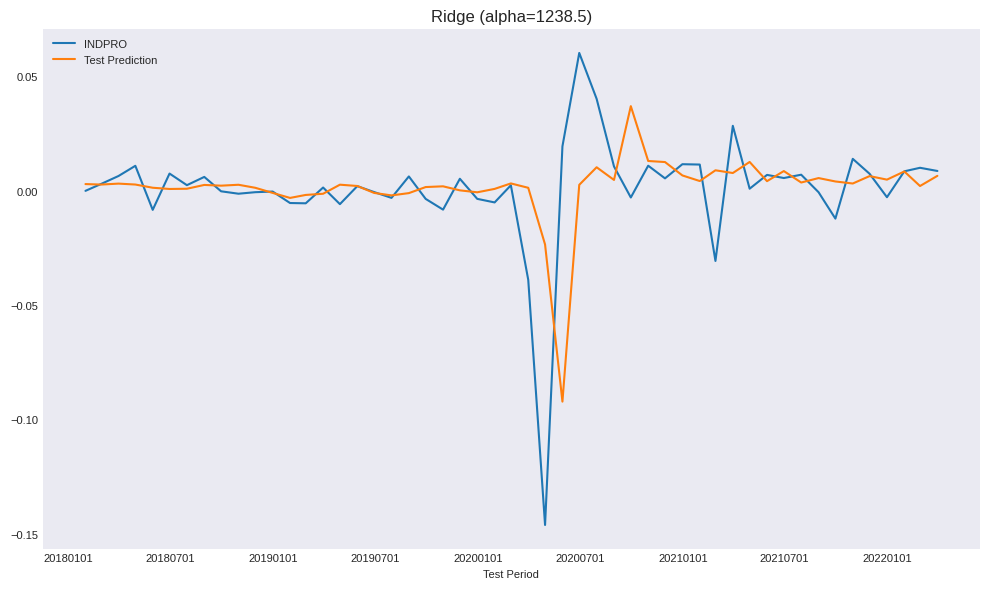

In [4]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.pipeline import Pipeline
alphas = 10**np.linspace(8, -4, 100)*0.5  # for parameter tuning
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)
np.random.seed(42)

### Plot fitted coefficients vs regularization alpha
coefs = [Ridge(alpha, fit_intercept=False)\
         .fit(X_subset, Y_train).coef_ for alpha in alphas]
fig, ax = plt.subplots(num=1, clear=True, figsize=(5, 3))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('value of alpha regularization parameter')
ax.set_title('Ridge Regression fitted coefficients')
plt.tight_layout()
plt.savefig(imgdir / 'ridge.jpg')



### RidgeCV LOOCV
model = RidgeCV(alphas=alphas,
                scoring='neg_mean_squared_error',
                cv=None,  # to use Leave-One-Out cross validation
                store_cv_values=True).fit(X_train, Y_train)

name = f"Ridge (alpha={model.alpha_:.1f})"
Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))
test[name] = mean_squared_error(Y_test, Y_pred)
robust = Y_test.abs() < 2.33 * np.std(Y_test)
test_robust[name] = mean_squared_error(Y_test[robust], Y_pred[robust])
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

fig, ax = plt.subplots(figsize=(10,6))
plot_date(pd.concat([Y_test, Y_pred], axis=1),
          legend1=[target_id, 'Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()
plt.savefig(imgdir / 'ridge_test.jpg')


DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test_robust': np.sqrt(test_robust[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])
    


##  Lasso Regression


/home/terence/env3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.939433662976735e-06, tolerance: 3.06196989500973e-06
  model = cd_fast.enet_coordinate_descent_gram(
/home/terence/env3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.275721962663029e-06, tolerance: 3.2902038096105723e-06
  model = cd_fast.enet_coordinate_descent_gram(
/home/terence/env3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9042555804960225e-06, tolerance: 3.06196989500973e-06
  model = cd_fast.enet_coordinate_descent_gram(


,lags,desc,coef
Lasso: Nonzero Coefficients,,,
NDMANEMP,1,"All Employees, Nondurable Goods",0.0008
CLAIMS,1,Initial Claims,-0.0006
CES2000000008,1,Average Hourly Earnings of Production and Nons...,0.0006
S&P div yield,2,S&P's Composite Common Stock: Dividend Yield,-0.0005
USTRADE,1,"All Employees, Retail Trade",0.0005
IPNMAT,3,Industrial Production: Non-Durable Goods Mater...,0.0005
AAA,1,Moody's Seasoned Aaa Corporate Bond Yield,0.0005
CES1021000001,3,"All Employees, Mining, Quarrying, and Oil and ...",-0.0004
EXCAUS,3,Canadian Dollars to U.S. Dollar Spot Exchange ...,-0.0004


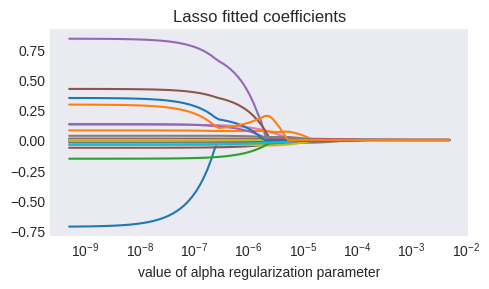

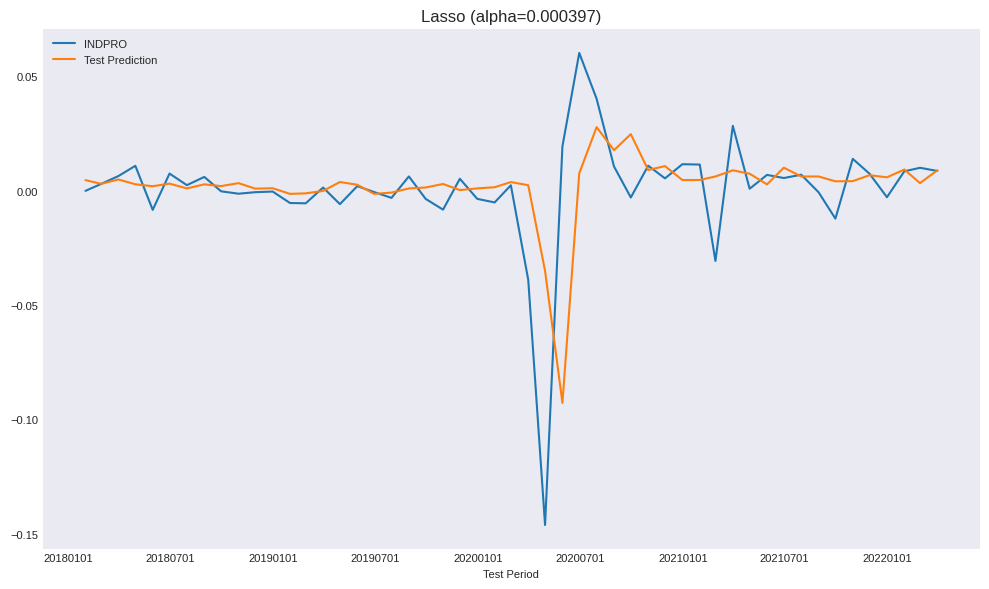

In [11]:
from sklearn.linear_model import Lasso, LassoCV
alphas = 10**np.linspace(-2, -9, 100)*0.5  # for parameter tuning
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

### Plot fitted coefficients vs regularization
coefs = [Lasso(max_iter=10000, alpha=alpha)\
         .fit(X_subset, Y_train).coef_  for alpha in alphas]
fig, ax = plt.subplots(num=3, clear=True, figsize=(5, 3))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('value of alpha regularization parameter')
ax.set_title('Lasso fitted coefficients')
plt.tight_layout()
plt.savefig(imgdir / 'lasso.jpg')


### LassoCV 10-Fold CV
model = LassoCV(alphas=None,
                cv=10,
                n_jobs=-1,
                verbose=VERBOSE,
                max_iter=10000).fit(X_train, Y_train)
name = f"Lasso (alpha={model.alpha_:.3g})"
Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))
test[name] = mean_squared_error(Y_test, Y_pred)
robust = Y_test.abs() < 2.33 * np.std(Y_test)
test_robust[name] = mean_squared_error(Y_test[robust], Y_pred[robust])
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

fig, ax = plt.subplots(figsize=(10,6))
plot_date(pd.concat([Y_test, Y_pred], axis=1),
          legend1=[target_id, 'Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()
plt.savefig(imgdir / 'lasso_test.jpg')


DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test_robust': np.sqrt(test_robust[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

### Display nonzero coefs
nonzero = np.sum(np.abs(model.coef_) > 0)
argsort = np.flip(np.argsort(np.abs(model.coef_)))[:nonzero]
df = DataFrame({'series_id': columns_unmap(X.columns[argsort])[0],
                'lags': columns_unmap(X.columns[argsort])[1],
                'desc': [alf.header(s)
                         for s in columns_unmap(X.columns[argsort])[0]],
                'coef': model.coef_[argsort]}).round(6).set_index('series_id')
show(df, max_colwidth=70, caption="Lasso: Nonzero Coefficients")





## Gradient boost


,importance,series_id,lags,description
Gradient Boosting: Feature Importances,,,,
1,0.0709,USGOOD,1,"All Employees, Goods-Producing"
2,0.0501,CMRMTSPL,2,Real Manufacturing and Trade Industries Sales
3,0.0439,IPNMAT,1,Industrial Production: Non-Durable Goods Mater...
4,0.0386,M2REAL,3,Real M2 Money Stock
5,0.0342,UNRATE,1,Unemployment Rate
6,0.0300,HWIURATIO,1,Ratio of Help Wanted/No. Unemployed
7,0.0271,DMANEMP,1,"All Employees, Durable Goods"
8,0.0255,ISRATIO,2,Total Business: Inventories to Sales Ratio
9,0.0254,NDMANEMP,1,"All Employees, Nondurable Goods"


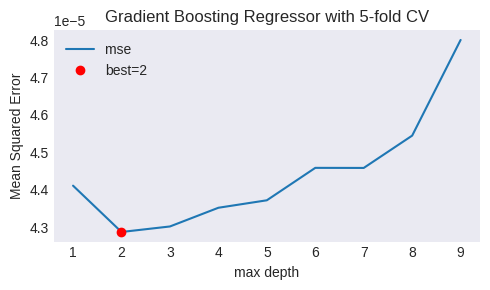

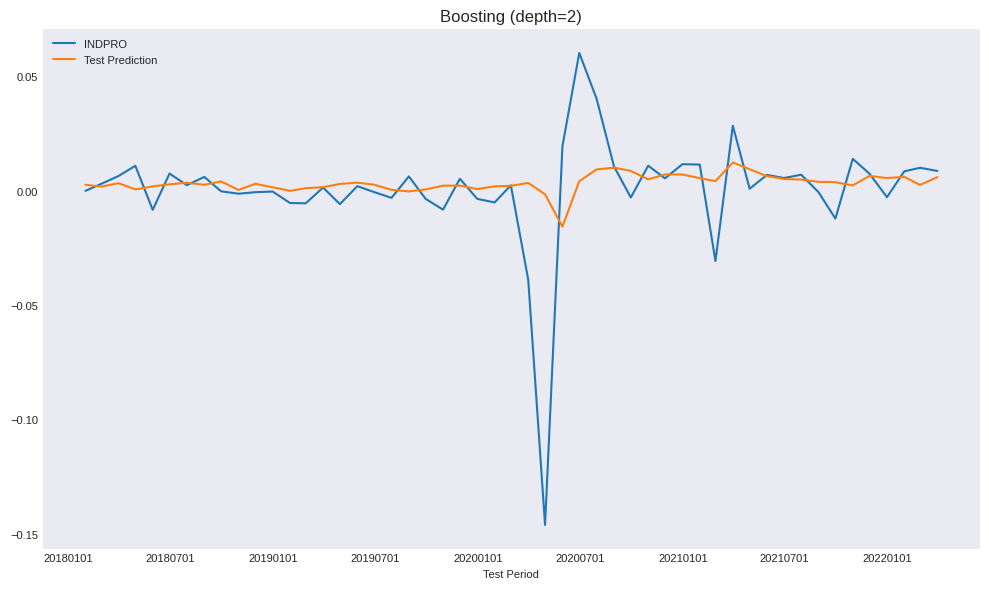

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

### tune max_depth with 5-fold CV
n_splits=5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
mse = Series(dtype=float)
for i in range(1, 10): # tune max_depth for best performance
    boosted = GradientBoostingRegressor(max_depth=i, random_state=0)
    score = cross_val_score(boosted,
                            X_train,
                            Y_train,
                            cv=kf,
                            n_jobs=-1,
                            verbose=VERBOSE,
                            scoring='neg_mean_squared_error').mean()
    mse.loc[i] = -score

fig, ax = plt.subplots(clear=True, num=1, figsize=(5, 3))
mse.plot(ax=ax, ylabel='Mean Squared Error', xlabel='max depth',
         title=f"Gradient Boosting Regressor with {n_splits}-fold CV")
best = mse.index[mse.argmin()]
ax.plot(best, mse.loc[best], "or")
ax.legend(['mse', f"best={best}"])
plt.tight_layout()
plt.savefig(imgdir / 'boosting.jpg')


### evaluate train and test MSE
name = f"Boosting (depth={best})"
model = GradientBoostingRegressor(max_depth=best,
                                  random_state=0).fit(X_train, Y_train)

Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))
test[name] = mean_squared_error(Y_test, Y_pred)
robust = Y_test.abs() < 2.33 * np.std(Y_test)
test_robust[name] = mean_squared_error(Y_test[robust], Y_pred[robust])
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

fig, ax = plt.subplots(figsize=(10,6))
plot_date(pd.concat([Y_test, Y_pred], axis=1),
          legend1=[target_id, 'Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()
plt.savefig(imgdir / 'boosting_test.jpg')


DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test_robust': np.sqrt(test_robust[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

### Show feature importance
top_n = 10
imp = Series(model.feature_importances_, index=X.columns).sort_values()
show(DataFrame.from_dict({i+1: {'importance': imp[s],
                                'series_id': s.split('_')[0],
                                'lags': s.split('_')[1],
                                'description': alf.header(s.split('_')[0])}
                          for i, s in enumerate(np.flip(imp.index[-top_n:]))},
                         orient='index'),
     max_colwidth=70, caption="Gradient Boosting: Feature Importances")

## Random Forest


3 0.006658748700334789
4 0.006595819691834476
5 0.006554813834111895
6 0.006525145608947737
7 0.006498070117454981
8 0.0065098589283977635
9 0.006500171449029663
10 0.00651232983315365
11 0.006483624005866995
12 0.0065079602075351186
13 0.006498528900854759
14 0.006500489917980369
15 0.00649950719243888
16 0.006508985777345642
17 0.0065033396940369125
18 0.006504936979291603
19 0.00650865115862167


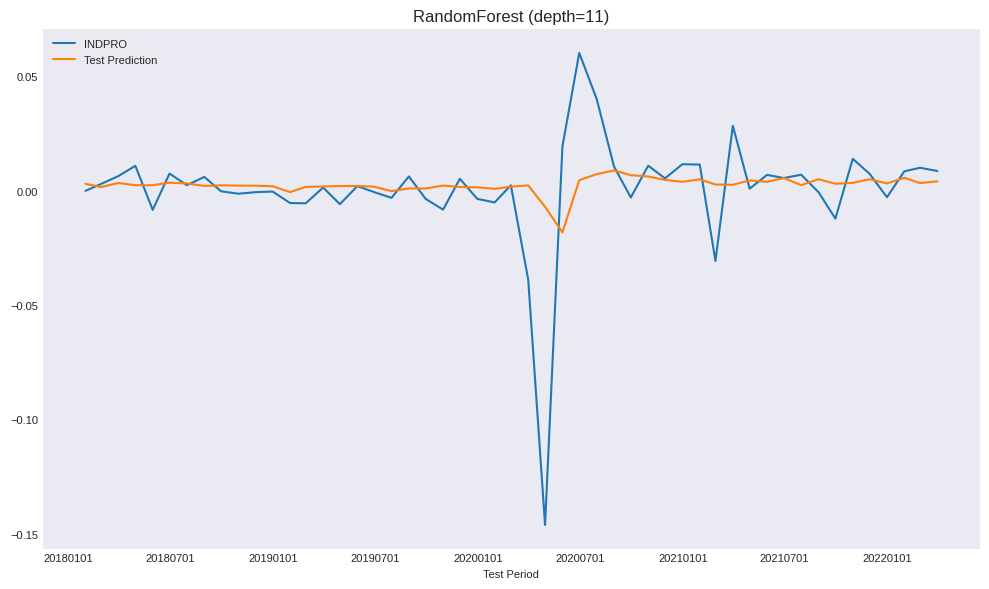

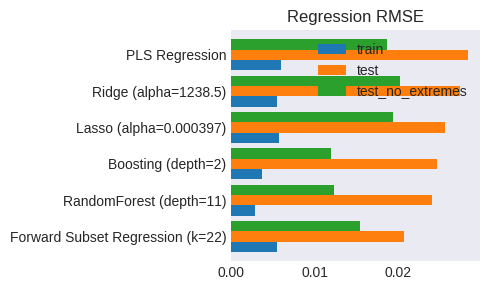

In [13]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, Y_train, Y_test = ts_split(X, Y)

### tune max_depth with 5-fold CV
n_splits=5
kf = KFold(n_splits=n_splits,
           shuffle=True,
           random_state=0)
mse = Series(dtype=float)
for i in range(3, 20): #tune for best performance
    model = RandomForestRegressor(max_depth=i, random_state=0)
    score = cross_val_score(model,
                            X_train,
                            Y_train,
                            cv=kf,
                            n_jobs=-1,
                            verbose=VERBOSE,
                            scoring='neg_mean_squared_error').mean()
    mse.loc[i] = -score
    print(i, np.sqrt(abs(score)))

fig, ax = plt.subplots(clear=True, num=1, figsize=(5, 3))
mse.plot(ax=ax, ylabel='MSE', xlabel='max depth',
         title=f"Random Forest Regressor with {n_splits}-fold CV")
best = mse.index[mse.argmin()]
ax.plot(best, mse.loc[best], "or")
ax.legend(['Mean Squared Error', f"best={best}"])
plt.tight_layout()
plt.savefig(imgdir / 'forest.jpg')


name = f"RandomForest (depth={best})"
model = RandomForestRegressor(max_depth=best,
                              random_state=0).fit(X_train, Y_train)

Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))
test[name] = mean_squared_error(Y_test, Y_pred)
robust = Y_test.abs() < 2.33 * np.std(Y_test)
test_robust[name] = mean_squared_error(Y_test[robust], Y_pred[robust])
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

fig, ax = plt.subplots(figsize=(10,6))
plot_date(pd.concat([Y_test, Y_pred], axis=1),
          legend1=[target_id, 'Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()
plt.savefig(imgdir / 'forest_test.jpg')


DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test_robust': np.sqrt(test_robust[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])
fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 5))           
pd.concat([np.sqrt(r.to_frame()) for r in [train, test, test_robust]], axis=1)\
  .sort_values('test')\
  .plot.barh(ax=ax, width=0.85)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_title('Regression RMSE')
ax.figure.subplots_adjust(left=0.35)
plt.tight_layout()
plt.savefig(imgdir / 'rmse.jpg')



## Feature Importances


In [14]:
top_n = 10
imp = Series(model.feature_importances_, index=X.columns).sort_values()
show(DataFrame.from_dict({i+1: {'importance': imp[s],
                                'series_id': s.split('_')[0],
                                'lags': s.split('_')[1],
                                'description': alf.header(s.split('_')[0])}
                          for i, s in enumerate(np.flip(imp.index[-top_n:]))},
                         orient='index'),
     max_colwidth=70, caption="Feature Importances with Random Forest")

,importance,series_id,lags,description
Feature Importances with Random Forest,,,,
1,0.0510,USGOOD,1,"All Employees, Goods-Producing"
2,0.0351,IPNMAT,1,Industrial Production: Non-Durable Goods Mater...
3,0.0265,UNRATE,1,Unemployment Rate
4,0.0224,M2REAL,3,Real M2 Money Stock
5,0.0222,MANEMP,1,"All Employees, Manufacturing"
6,0.0185,DMANEMP,1,"All Employees, Durable Goods"
7,0.0180,TB6SMFFM,1,6-Month Treasury Bill Minus Federal Funds Rate
8,0.0159,CMRMTSPL,2,Real Manufacturing and Trade Industries Sales
9,0.0158,PAYEMS,1,"All Employees, Total Nonfarm"


## RMSE's


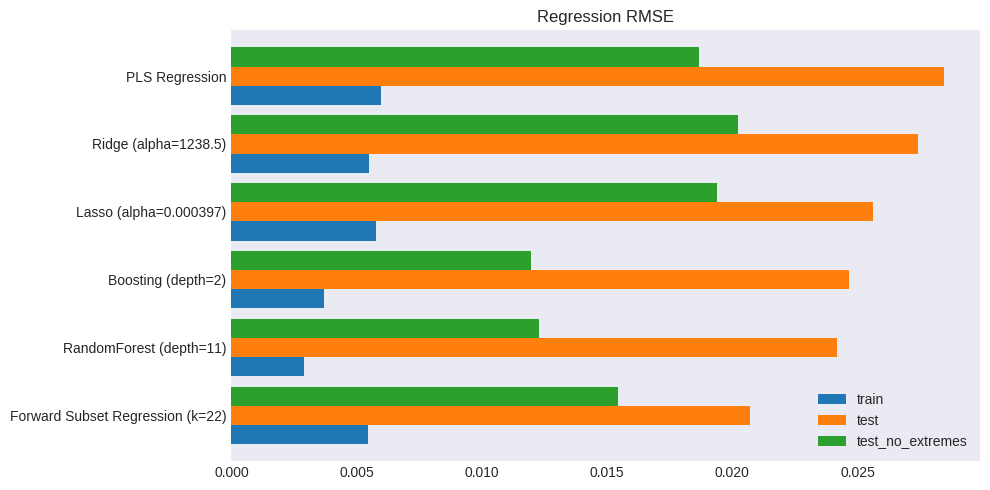

In [15]:
# np.sqrt(train.rename('train').to_frame().join(test.rename('test')))\

fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 5))
pd.concat([np.sqrt(r.to_frame()) for r in [train, test, test_robust]], axis=1)\
  .sort_values('test')\
  .plot.barh(ax=ax, width=0.85)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_title('Regression RMSE')
ax.figure.subplots_adjust(left=0.35)
plt.tight_layout()
plt.savefig(imgdir / 'rmse.jpg')

#
# TODO
# 1. predict 5 years, raw (don't no extremes)
#